In [60]:
from siphon.catalog import TDSCatalog
from datetime import datetime
from xarray.backends import NetCDF4DataStore
import xarray as xr
from metpy.units import units
import numpy as np
import metpy.calc as mpcalc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [61]:
def find_time_var(var, time_basename='time'):
    for coord_name in var.coords:
        if coord_name.startswith(time_basename):
            return var.coords[coord_name]
    return ValueError('No time variable found')


In [62]:
catalog_url = 'https://thredds-test.unidata.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/catalog.xml'
dataset_name = 'Best GFS Quarter Degree Forecast Time Series'
cat = TDSCatalog(catalog_url)
dataset = cat.datasets[dataset_name]
ncss = dataset.subset()
query = ncss.query()
query.lonlat_box(north=50, south=25, east=-75, west=-122).time(datetime.utcnow())
query.accept('netcdf4')
query.variables('u-component_of_wind_isobaric', 'v-component_of_wind_isobaric', 'Geopotential_height_isobaric')

data = ncss.get_data(query)
data = xr.open_dataset(NetCDF4DataStore(data))
list(data)

['u-component_of_wind_isobaric',
 'v-component_of_wind_isobaric',
 'Geopotential_height_isobaric',
 'LatLon_721X1440-0p13S-180p00E-2']

In [63]:
wind_u = data['u-component_of_wind_isobaric']
wind_v = data['v-component_of_wind_isobaric']
heights = data['Geopotential_height_isobaric']
time_1d = find_time_var(wind_u)

lon = wind_u.metpy.longitude 
lat = wind_v.metpy.latitude
lon_2d, lat_2d = np.meshgrid(lon, lat)

In [64]:
u_wind = wind_u.sel(isobaric=50000 * units.Pa).isel(time=0)
v_wind = wind_v.sel(isobaric=50000 * units.Pa).isel(time=0)
height = heights.sel(isobaric=50000 * units.Pa).isel(time=0)

C:\Users\Tony\anaconda3\lib\site-packages\xarray\core\indexes.py:244: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result = np.asarray(values)


In [65]:
geostrophic_u,geostrophic_v = mpcalc.geostrophic_wind(height)
ageostrophic_u = u_wind.values * units('m/s') - geostrophic_u
ageostrophic_v = v_wind.values * units('m/s') - geostrophic_v

C:\Users\Tony\anaconda3\lib\site-packages\xarray\core\variable.py:314: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


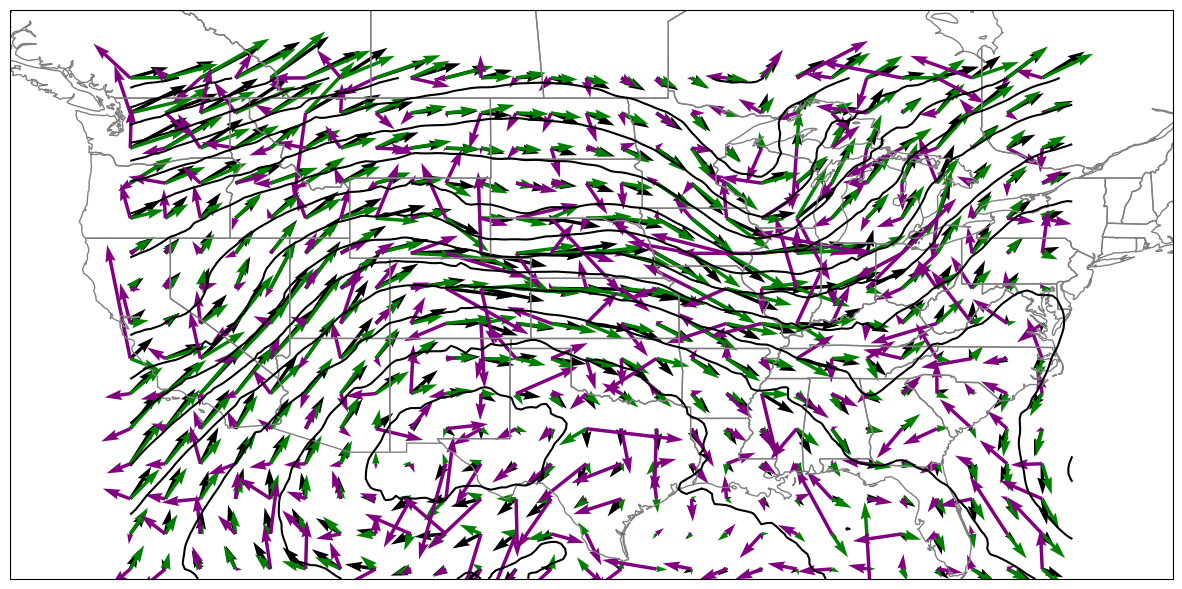

In [66]:
fig = plt.figure(figsize=(15,12))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -70, 25, 50])

ax.add_feature(cfeature.STATES, edgecolor='gray')

decimate = slice(None, None, 7)
ax.quiver(lon_2d[decimate, decimate], lat_2d[decimate, decimate], u_wind[decimate, decimate], v_wind[decimate, decimate])
ax.quiver(lon_2d[decimate, decimate], lat_2d[decimate, decimate], geostrophic_u[decimate, decimate], geostrophic_v[decimate, decimate], color='green')
ax.quiver(lon_2d[decimate, decimate], lat_2d[decimate, decimate], ageostrophic_u[decimate, decimate], ageostrophic_v[decimate, decimate], color='purple')
ax.contour(lon_2d, lat_2d, height, colors = 'black', levels = np.arange(5000, 6000, 20))
plt.title('H500 Ageostrophic Wind')
plt.show()